In [ ]:
import torch, matplotlib.pyplot as plt
import numpy as np

# ---- (A) log density of target p(x) = ½ N(-8,2²) + ½ N(+8,1²) -------------------
def log_p_pdf(x):
    # logp1 = torch.distributions.Normal(-8., 2.).log_prob(x)
    # logp2 = torch.distributions.Normal(+8., 1.).log_prob(x)
    # return torch.logsumexp(torch.stack([logp1, logp2]), dim=0) - np.log(2)

    # -------- target mixture parameters ------------------------------------------
    pi      = torch.tensor([0.15, 0.75])              # 25 % vs 75 % mass
    mus     = torch.tensor([-5.0,  5.0])              # mode locations
    sigmas  = torch.tensor([ 3.0,  3.0])              # std-devs (narrow vs wide)

    # # -------- target mixture parameters ------------------------------------------
    # pi      = torch.tensor([0.15, 0.35])              # 25 % vs 75 % mass
    # mus     = torch.tensor([-5.0,  5.0])              # mode locations
    # sigmas  = torch.tensor([ 1.5,  2])              # std-devs (narrow vs wide)

    cat  = torch.distributions.Categorical(pi)
    comp = torch.distributions.Normal(mus, sigmas)
    p    = torch.distributions.MixtureSameFamily(cat, comp)   # full target distr.
    return p.log_prob(x)

# ---- (B) reverse KL: E_q[log q - log p] ---------------------------------------
mu = torch.tensor(+0.0, requires_grad=True)
log_sigma = torch.tensor(np.log(4.0), requires_grad=True)
opt = torch.optim.Adam([mu, log_sigma], lr=5e-2)

# schedule = {0, 1, 5, 10, 20, 50, 100, 200, 500, 1000}
schedule = {1000}
snapshots = []

for step in range(1001):
    sigma = log_sigma.exp()
    q = torch.distributions.Normal(mu, sigma)
    x_sample = q.rsample((4000,))  # Reparameterized sampling

    logq = q.log_prob(x_sample)
    logp = log_p_pdf(x_sample)

    kl = torch.mean(logq - logp)  # reverse KL
    # common approximation of reverse KL
    # kl = ((logp - logq).exp() - (logp - logq) - 1).mean()

    # # reverse KL with linear interpolation, between logq and logp
    # alpha = 0.1
    # interpolation = torch.log(alpha * logq.exp() + (1 - alpha) * logp.exp())
    # kl = (logq - interpolation).mean()

    opt.zero_grad()
    kl.backward()
    opt.step()

    if step in schedule:
        snapshots.append((step, mu.item(), sigma.item(), kl.item()))

# ---- (C) plot training trajectory ---------------------------------------------
xs = torch.linspace(-20, 20, 4001)
px = log_p_pdf(xs).exp().detach().numpy()

plt.figure(figsize=(8,4))
plt.plot(xs.numpy(), px, 'k', lw=2, label="target  $p(x)$")

# Plot initial q(x) = N(0, 4^2)
init_mu, init_sigma = 0.0, 4.0
qx_init = torch.distributions.Normal(init_mu, init_sigma).log_prob(xs).exp().numpy()
plt.plot(xs.numpy(), qx_init, 'k--', lw=1.5, label=r'initial $q(x) \sim \mathcal{N}(0, 4^2)$')


cmap = plt.cm.plasma(np.linspace(0, 1, len(snapshots)))
for c, (t, m, s, _) in zip(cmap, snapshots):
    qx = torch.distributions.Normal(m, s).log_prob(xs).exp().numpy()
    plt.plot(xs.numpy(), qx, color=c, lw=1.8,
             label=f'step {t:3d}   μ={m:5.2f}  σ={s:5.2f}')

plt.title('Reverse-KL training of Gaussian $q$')
plt.xlim(-20, 20); plt.ylim(0, 0.15)
plt.legend(fontsize=7, ncol=2)
plt.tight_layout(); plt.show()


In [ ]:
import torch, matplotlib.pyplot as plt
import numpy as np


class KLTrainer:
    def __init__(self, kl_method="reverse", alpha=0.1, steps=1001, lr=5e-2):
        # Target distribution parameters (mixture of Gaussians)
        self.pi     = torch.tensor([0.15, 0.75])
        self.mus    = torch.tensor([-5.0, 5.0])
        self.sigmas = torch.tensor([3.0, 3.0])

        # Variational distribution parameters (univariate Gaussian)
        self.mu = torch.tensor(-10.0, requires_grad=True)
        self.log_sigma = torch.tensor(np.log(4.0), requires_grad=True)

        # Store initial values for plotting
        self.init_mu = self.mu.clone().detach()
        self.init_sigma = self.log_sigma.clone().detach().exp()

        # Training config
        self.kl_method = kl_method
        self.alpha = alpha
        self.steps = steps
        self.opt = torch.optim.Adam([self.mu, self.log_sigma], lr=lr)
        self.snapshots = []
        self.schedule = {0, 1, 5, 10, 20, 50, 100, 200, 500, 1000}

    def log_p_pdf(self, x):
        cat  = torch.distributions.Categorical(self.pi)
        comp = torch.distributions.Normal(self.mus, self.sigmas)
        p    = torch.distributions.MixtureSameFamily(cat, comp)
        return p.log_prob(x)

    def sample_p(self, n):
        cat  = torch.distributions.Categorical(self.pi)
        comp = torch.distributions.Normal(self.mus, self.sigmas)
        p    = torch.distributions.MixtureSameFamily(cat, comp)
        return p.sample((n,))

    def compute_kl(self, logp, logq):
        if self.kl_method == "reverse":
            return torch.mean(logq - logp)
        elif self.kl_method == "reverse_approx":
            return torch.mean((logp - logq).exp() - (logp - logq) - 1)
        elif self.kl_method == "reverse_interp":
            interp = torch.log(self.alpha * logq.exp() + (1 - self.alpha) * logp.exp())
            # return torch.mean(logq - interp)
            return torch.mean((interp - logq).exp() - (interp - logq) - 1)
        elif self.kl_method == "forward":
            return torch.mean(logp - logq)
        elif self.kl_method == "reverse_cross_entropy":
            return  torch.mean(logp)
        elif self.kl_method == "reverse_min_entropy":
            return  torch.mean(logq)
        else:
            raise ValueError(f"Unknown KL method: {self.kl_method}")

    def train(self):
        for step in range(self.steps):
            sigma = self.log_sigma.exp()
            q = torch.distributions.Normal(self.mu, sigma)

            if self.kl_method.startswith("reverse"):
                x_sample = q.rsample((4000,))
            else:
                x_sample = self.sample_p(4000).detach()

            logq = q.log_prob(x_sample)
            logp = self.log_p_pdf(x_sample)

            kl = self.compute_kl(logp, logq)

            self.opt.zero_grad()
            kl.backward()
            self.opt.step()

            # keep σ in a reasonable range
            with torch.no_grad():
                self.log_sigma.clamp_(min=np.log(1e-4), max=np.log(1e4))

            if step in self.schedule:
                self.snapshots.append((step, self.mu.item(), sigma.item(), kl.item()))

    def plot(self):
        xs = torch.linspace(-20, 20, 4001)
        px = self.log_p_pdf(xs).exp().detach().numpy()

        plt.figure(figsize=(8, 4))
        plt.plot(xs.numpy(), px, 'k', lw=2, label="target $p(x)$")

        # Plot initial q(x) using stored init_mu, init_sigma
        qx_init = torch.distributions.Normal(self.init_mu, self.init_sigma).log_prob(xs).exp().numpy()
        label = rf'initial $q(x) \sim \mathcal{{N}}({self.init_mu.item():.1f}, {self.init_sigma.item():.1f}^2)$'
        plt.plot(xs.numpy(), qx_init, 'k--', lw=1.5, label=label)

        cmap = plt.cm.magma(np.linspace(0, 1, len(self.snapshots)))
        for c, (t, m, s, _) in zip(cmap[-1:], self.snapshots[-1:]):
            qx = torch.distributions.Normal(m, s).log_prob(xs).exp().numpy()
            plt.plot(xs.numpy(), qx, color='blue', lw=1.8,
                    label=f'step {t:3d}   μ={m:5.2f}  σ={s:5.2f}')


        plt.title(f'Training $q(x)$ using {self.kl_method}')
        plt.xlim(-20, 20)
        plt.ylim(0, 0.15)
        plt.legend(fontsize=7, ncol=2)
        plt.tight_layout()
        plt.show()


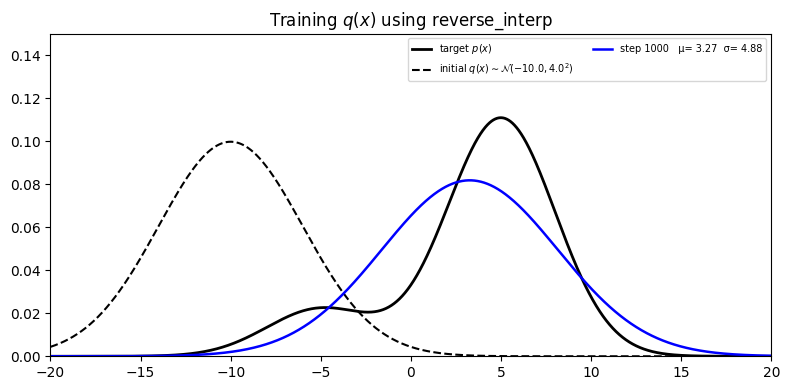

In [ ]:
trainer = KLTrainer(kl_method="reverse_interp", steps=1001, alpha=0.8)
trainer.train()
trainer.plot()


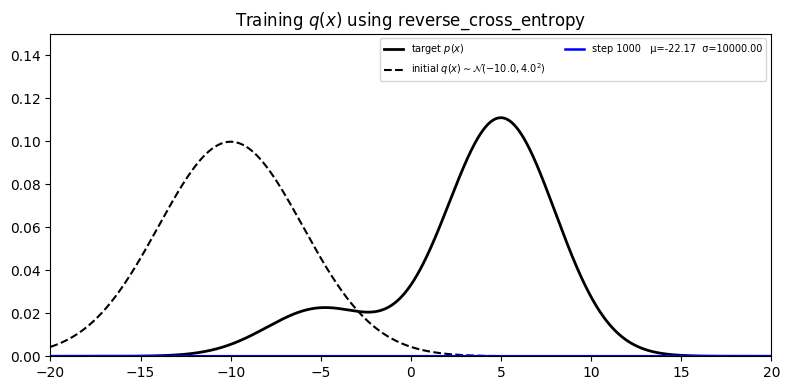

In [35]:
# trainer = KLTrainer(kl_method="reverse", steps=1001, alpha=0.1, lr=5e-2)
# trainer = KLTrainer(kl_method="reverse_approx", steps=1001, alpha=0.1, lr=5e-1)
# trainer = KLTrainer(kl_method="forward", steps=1001, alpha=0.1, lr=5e-2)
# trainer = KLTrainer(kl_method="reverse_min_entropy", steps=1001, alpha=0.1, lr=5e-2)
trainer = KLTrainer(kl_method="reverse_cross_entropy", steps=1001, alpha=0.1, lr=5e-2)
trainer.train()
trainer.plot()


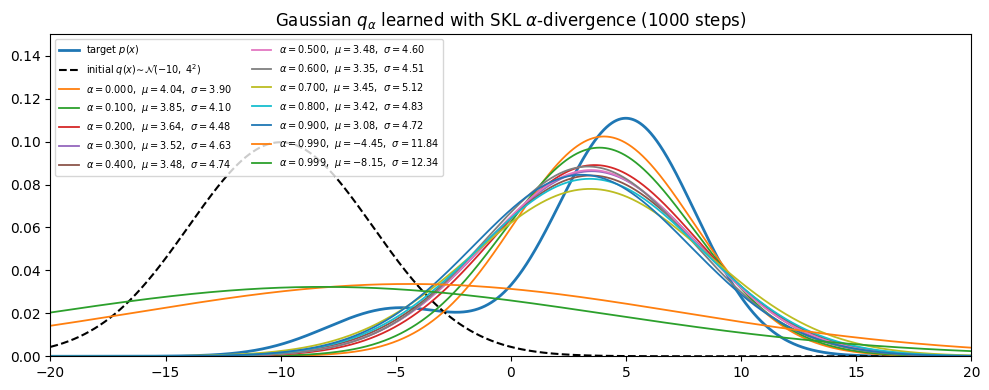

In [15]:
import torch, matplotlib.pyplot as plt, numpy as np

# ────────────────────────────────────────────────────────────────────────────────
# 1.  Trainer (unchanged except for a couple of convenience tweaks)
# ────────────────────────────────────────────────────────────────────────────────
class KLTrainer:
    def __init__(self, *, alpha, steps=1001, lr=5e-2, n_samples=2000):
        # target p(x)   = 0.15⋅𝒩(−5,3²) + 0.75⋅𝒩(+5,3²)
        self.pi     = torch.tensor([0.15, 0.75])
        self.mus    = torch.tensor([-5.0, 5.0])
        self.sigmas = torch.tensor([3.0,  3.0])

        # variational q(x) = 𝒩(μ,σ²)  (start far off on purpose)
        self.mu         = torch.tensor(-10.0,   requires_grad=True)
        self.log_sigma  = torch.tensor(np.log(4.0), requires_grad=True)

        self.alpha   = alpha
        self.steps   = steps
        self.n       = n_samples
        self.opt     = torch.optim.Adam([self.mu, self.log_sigma], lr=lr)

    # log p(x)
    def log_p_pdf(self, x):
        mix = torch.distributions.MixtureSameFamily(
            torch.distributions.Categorical(self.pi),
            torch.distributions.Normal(self.mus, self.sigmas)
        )
        return mix.log_prob(x)

    # one training run
    def train(self):
        for _ in range(self.steps):
            sigma = self.log_sigma.exp()
            q     = torch.distributions.Normal(self.mu, sigma)
            x     = q.rsample((self.n,))                 # draw from q
            logq  = q.log_prob(x)
            logp  = self.log_p_pdf(x)

            # reverse-interp α-divergence
            interp = torch.log(self.alpha * logq.exp() + (1.0 - self.alpha) * logp.exp())
            loss   = torch.mean(logq - interp)           # minimise KL_α

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

        # final parameters
        return self.mu.item(), self.log_sigma.exp().item()

# ────────────────────────────────────────────────────────────────────────────────
# 2.  Train for a sweep of α values
# ────────────────────────────────────────────────────────────────────────────────
alphas   = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50,
            0.60, 0.70, 0.80, 0.90, 0.99, 0.999]

results  = {}
for a in alphas:
    trainer          = KLTrainer(alpha=a)
    mu, sigma        = trainer.train()
    results[a]       = (mu, sigma)

# ────────────────────────────────────────────────────────────────────────────────
# 3.  Plot all the final qα(x) curves + p(x)  + initial q0(x)
# ────────────────────────────────────────────────────────────────────────────────
xs  = torch.linspace(-20, 20, 4001)
# target density
mix = torch.distributions.MixtureSameFamily(
          torch.distributions.Categorical(torch.tensor([0.15, 0.75])),
          torch.distributions.Normal(torch.tensor([-5., 5.]), torch.tensor([3., 3.])))
px  = mix.log_prob(xs).exp().detach()

plt.figure(figsize=(10, 4))
plt.plot(xs, px, lw=2, label="target $p(x)$")

# initial q(x) = 𝒩(-10,4²)
qx_init = torch.distributions.Normal(-10., 4.).log_prob(xs).exp()
plt.plot(xs, qx_init, 'k--', lw=1.5,
         label=r'initial $q(x)\!\sim\!\mathcal{N}(-10,\;4^{2})$')

# learned qα(x) curves
for a, (m, s) in results.items():
    qx = torch.distributions.Normal(m, s).log_prob(xs).exp()
    plt.plot(xs, qx, lw=1.3,
             label=rf"$\alpha={a:.3f}$,  $\mu={m:.2f}$,  $\sigma={s:.2f}$")

plt.title(r"Gaussian $q_\alpha$ learned with SKL $\alpha$-divergence ($1000$ steps)")
plt.xlim(-20, 20)
plt.ylim(0, 0.15)
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()
